In [2]:
import sys
!{sys.executable} -m pip install ucimlrepo
from ucimlrepo import fetch_ucirepo 

from pygam import LinearGAM, s, f

import torch
import torch.nn as nn # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F # All functions that don't have any parameters
from torch.autograd import Variable

from sklearn.metrics.pairwise import rbf_kernel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from quantile_forest import RandomForestQuantileRegressor


import cvxpy as cp
import numpy as np
from numpy import linalg
import pandas as pd

from scipy.linalg import sqrtm
from scipy.stats import iqr


from matplotlib import pyplot as plt

import seaborn as sns
import matplotlib.patches as patches
import matplotlib.lines as lines

import warnings
random_seed = 42


if torch.cuda.is_available():
    print("GPU is available.")
    device = torch.device('cuda')
else:
    print("GPU is not available.")
    device = torch.device('cpu')

GPU is not available.


In [3]:
energy_efficiency = fetch_ucirepo(id=242) 

X = energy_efficiency.data.features 
y = energy_efficiency.data.targets 

X_numeric= X.to_numpy()
X_numeric[:,1] = np.log(X_numeric[:,1])
X_numeric[:,2] = np.log(X_numeric[:,2])
X_numeric[:,3] = np.log(X_numeric[:,3])


y_numeric = y.to_numpy()[:,0].reshape(-1, 1)

Data = np.hstack((y_numeric, X_numeric)) 

beta = np.array([-1, 0, 1, 0, -1, 0, 0, -1])

def mydata(Data, beta, prop = 0.75):
    
    # random split the data from source into two parts: training and testing data
    np.random.shuffle(Data)
    train_idx = int(Data.shape[0] * prop)
    Dtrain, Dtest = np.split(Data, [train_idx])
    
    # creat the shift data set
    probabilities = np.exp(Dtest[:,1:].dot(beta)) # Calculate probabilities proportional to w(x) = exp(x^T * beta)
    probabilities /= np.sum(probabilities) # Normalize probabilities
    
    sample_indices = np.random.choice(len(Dtest), size=len(Dtest), replace=True, p=probabilities)
    Dshift = Dtest[sample_indices]
    
    return Dtrain, Dtest, Dshift

In [4]:
class NN1(nn.Module):
    def __init__(self, input_size, output_size):
        super(NN1, self).__init__()
        self.fc1 = nn.Linear(input_size, 10)
        self.fc2 = nn.Linear(10, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# 2-layer NN
class NN2(nn.Module):
    def __init__(self, input_size, output_size):
        super(NN2, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x 
    
    
    
class QuantileLoss(nn.Module):
    def __init__(self, quantile):
        super().__init__()
        self.quantile = quantile

    def forward(self, preds, target):
        assert not target.requires_grad
        assert preds.size(0) == target.size(0)
        residuals = target - preds
        return torch.max((self.quantile - 1) * residuals, self.quantile * residuals).mean()
        
        
def est_quantile(est_type,quantile,X_pre,Y_pre,X_opt,X_adj,X_t):
    """
        est_type: 
        "NN1": 1-layer NN;              "NN2": 2-layer NN; 
        "qrf": quantile regression forest;    "gb": gradient boosting
        
        quantile: the quantile we are estimating
        (X_pre,Y_pre): training data
        X_opt,X_adj,X_t: data used to predict
        output: quantile estimator Q and the prediction Q(X) 
    """
    
    if est_type == "NN1":
        torch.manual_seed(42)
        torch.cuda.manual_seed_all(42)
        
        # Convert numpy arrays to torch tensors
        X = torch.from_numpy(X_pre).float().to(device)
        Y = torch.from_numpy(Y_pre).float().to(device)
        input_size = X.shape[1]
        
        model = NN1(input_size=input_size, output_size=1).to(device)
        learning_rate = 0.001
        
        # Set loss function and optimizer
        criterion = QuantileLoss(quantile).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        
        # Training loop
        for epoch in range(1000):
            optimizer.zero_grad()   # zero the gradient buffers
            output = model(X)
            loss = criterion(output, Y)
            loss.backward()
            optimizer.step()    # Does the update
            
        # Predict
        X_opt = torch.from_numpy(X_opt).float().to(device)
        X_adj = torch.from_numpy(X_adj).float().to(device)
        X_t = torch.from_numpy(X_t).float().to(device)

        Q_opt = model(X_opt)
        Q_opt = Q_opt.detach().cpu().numpy().reshape(-1,1)
        Q_adj = model(X_adj)
        Q_adj = Q_adj.detach().cpu().numpy().reshape(-1,1)
        Q_t = model(X_t)
        Q_t = Q_t.detach().cpu().numpy().reshape(-1,1)
        return model, Q_opt, Q_adj, Q_t
    
    if est_type == "NN2":
        torch.manual_seed(42)
        torch.cuda.manual_seed_all(42) 
        
        # Convert numpy arrays to torch tensors
        X = torch.from_numpy(X_pre).float().to(device)
        Y = torch.from_numpy(Y_pre).float().to(device)
        input_size = X.shape[1]
        
        model = NN2(input_size=input_size, output_size=1).to(device)
        learning_rate = 0.001
        
        # Set loss function and optimizer
        criterion = QuantileLoss(quantile).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        
        # Training loop
        for epoch in range(1000):
            optimizer.zero_grad()   # zero the gradient buffers
            output = model(X)
            loss = criterion(output, Y)
            loss.backward()
            optimizer.step()    # Does the update
            
        # Predict
        X_opt = torch.from_numpy(X_opt).float().to(device)
        X_adj = torch.from_numpy(X_adj).float().to(device)
        X_t = torch.from_numpy(X_t).float().to(device)

        Q_opt = model(X_opt)
        Q_opt = Q_opt.detach().cpu().numpy().reshape(-1,1)
        Q_adj = model(X_adj)
        Q_adj = Q_adj.detach().cpu().numpy().reshape(-1,1)
        Q_t = model(X_t)
        Q_t = Q_t.detach().cpu().numpy().reshape(-1,1)
        return model, Q_opt, Q_adj, Q_t
    
    if est_type == "qrf":
        model = RandomForestQuantileRegressor(n_estimators = 500, random_state=random_seed)
        model.fit(X_pre, Y_pre)
        Q_opt = model.predict(X_opt,quantiles = [quantile]).reshape(-1,1)
        Q_adj = model.predict(X_adj,quantiles = [quantile]).reshape(-1,1)
        Q_t = model.predict(X_t,quantiles = [quantile]).reshape(-1,1)
        return model, Q_opt, Q_adj, Q_t
    
    
    if est_type == "gb":
        model = GradientBoostingRegressor(n_estimators=300,random_state=random_seed,loss = "quantile", alpha = quantile)
        model.fit(X_pre, Y_pre)
        Q_opt = model.predict(X_opt).reshape(-1,1)
        Q_adj = model.predict(X_adj).reshape(-1,1)
        Q_t = model.predict(X_t).reshape(-1,1)
        return model, Q_opt, Q_adj, Q_t


In [6]:
def run_utopia(mc_iter):
    Dtrain, Dtest, Dshift = mydata(Data, beta)
    
    total_attributes = Dtrain.shape[1]
    Y_train = Dtrain[:,0]
    X_train = Dtrain[:,1:total_attributes]

    X_test = Dshift[:,1:total_attributes]
    Y_test = Dshift[:,0]


    pre_idx = int(Dtrain.shape[0] * 0.5)
    Dtrain_pre, Dtrain_opt = np.split(Dtrain, [pre_idx])
    adj_idx = int(Dtrain_opt.shape[0] * 0.5)
    Dtrain_opt, Dtrain_adj = np.split(Dtrain_opt, [adj_idx])

    X_pre = Dtrain_pre[:,1:]
    Y_pre = Dtrain_pre[:,0]

    X_opt = Dtrain_opt[:,1:]
    Y_opt = Dtrain_opt[:,0]

    X_adj = Dtrain_adj[:,1:]
    Y_adj = Dtrain_adj[:,0]
    
    #mean_model = RandomForestRegressor(n_estimators = 1000, random_state = 42)
#     mean_model = LinearRegression()
#     mean_model.fit(X_pre, Y_pre)
    
    mean_model = LinearGAM()
    mean_model.fit(X_pre, Y_pre)
    
    ## change it to linear model 

    mean_est_pre = mean_model.predict(X_pre)
    mean_est_opt = mean_model.predict(X_opt)
    mean_est_adj = mean_model.predict(X_adj)

    Y_centered_squared_pre = (Y_pre - mean_est_pre)**2 
    Y_centered_squared_opt = (Y_opt - mean_est_opt)**2 
    Y_centered_squared_adj = (Y_adj - mean_est_adj)**2 
    
    quantile = [0.85,0.95,0.9,0.9]


    m1,Q1_opt,Q1_adj,Q1_t = est_quantile("NN1",quantile[0],X_pre,Y_centered_squared_pre,X_opt,X_adj,X_test) # quantile def
    m2,Q2_opt,Q2_adj,Q2_t = est_quantile("NN2",quantile[1],X_pre,Y_centered_squared_pre,X_opt,X_adj,X_test)
    m3,Q3_opt,Q3_adj,Q3_t = est_quantile("qrf",quantile[2],X_pre,Y_centered_squared_pre,X_opt,X_adj,X_test)
    m4,Q4_opt,Q4_adj,Q4_t = est_quantile("gb",quantile[3],X_pre,Y_centered_squared_pre,X_opt,X_adj,X_test)
    

    ######## Variance estimator ###########
    
    rf_var_model = RandomForestRegressor(n_estimators = 1000, random_state = 42, max_depth = 10)
    rf_var_model.fit(X_pre, Y_centered_squared_pre)
    var_hat_pre = rf_var_model.predict(X_pre)
    var_hat_adj = rf_var_model.predict(X_adj)
    var_hat_opt = rf_var_model.predict(X_opt)
    var_hat_test = rf_var_model.predict(X_test)
    
    E_opt = np.vstack((np.matrix.flatten(Q1_opt), np.matrix.flatten(Q2_opt), np.matrix.flatten(Q3_opt), np.matrix.flatten(Q4_opt), var_hat_opt))
    E_adj = np.vstack((np.matrix.flatten(Q1_adj), np.matrix.flatten(Q2_adj), np.matrix.flatten(Q3_adj), np.matrix.flatten(Q4_adj), var_hat_adj))
    E_test = np.vstack((np.matrix.flatten(Q1_t), np.matrix.flatten(Q2_t), np.matrix.flatten(Q3_t), np.matrix.flatten(Q4_t), var_hat_test))
    
    n_opt = X_opt.shape[0]
    n_adj = X_adj.shape[0]
    n_test = X_test.shape[0]

    cons_opt = np.ones(n_opt).reshape(1,-1)
    cons_adj = np.ones(n_adj).reshape(1,-1)
    cons_test = np.ones(n_test).reshape(1,-1)

    A_opt = np.vstack((E_opt,cons_opt))
    A_adj = np.vstack((E_adj,cons_adj))
    A_test = np.vstack((E_test,cons_test))

    weight = cp.Variable(A_opt.shape[0])


    constraints = [weight>=0]+[weight @ A_opt >= Y_centered_squared_opt]  ### Change the objective 
    prob = cp.Problem(cp.Minimize(cp.sum(weight @ A_test)), constraints)
    prob.solve()
    optimal_weight = weight.value

    f_hat_init_opt = optimal_weight @  A_opt
    f_hat_init_adj = optimal_weight @  A_adj
    f_hat_init_test = optimal_weight @ A_test
    
    f_hat_init_adj[f_hat_init_adj < 0] = 0
    f_hat_init_test[f_hat_init_test < 0] = 0
    
    domain_cov = np.vstack((X_pre, X_test))
    domain_idx =  np.vstack((np.zeros(X_pre.shape[0]).reshape(-1,1), np.ones(X_test.shape[0]).reshape(-1,1)))
    domain_idx = np.matrix.flatten(domain_idx)

    logistic_model = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000,random_state=0) 
    logistic_model.fit(domain_cov, domain_idx)

    prob_hat = logistic_model.predict_proba(X_adj)[:,0]
    prob_hat = np.clip(prob_hat, 0.01, 0.99)
    est_ratio = prob_hat/(1-prob_hat) #### Multiplying by the constant or normalization #####
    #est_ratio /= est_ratio.mean()
    est_ratio = est_ratio * (X_pre.shape[0]/X_test.shape[0])
    
    
    delta = 1.01
    alpha = 0.05
    stepsize = 0.005
    prop_outside = np.mean(est_ratio * ((Y_centered_squared_adj/(f_hat_init_adj + 1e-10)) > delta))
    while prop_outside <= alpha:
        delta = delta - stepsize
        prop_outside = np.mean(est_ratio * ((Y_centered_squared_adj/(f_hat_init_adj + 1e-10)) > delta))
        
    mean_est_test = mean_model.predict(X_test)
    Y_centered_squared_test = (Y_test - mean_est_test)**2 
    cov = np.mean(Y_centered_squared_test < (delta * f_hat_init_test))
    bw = 2 * np.mean((delta * f_hat_init_test) ** 0.5)
    return cov, bw

In [7]:
from joblib import Parallel, delayed
results_utopia = Parallel(n_jobs=10)(delayed(run_utopia)(mc_iter) for mc_iter in range(200))

In [9]:
coverage_utopia = np.array(results_utopia)[:,0]
bandwidth_utopia = np.array(results_utopia)[:,1]
print(np.median(coverage_utopia))
print(np.median(bandwidth_utopia))
print(np.median(bandwidth_utopia[coverage_utopia >= 0.95]))
print(iqr(coverage_utopia))
print(iqr(bandwidth_utopia))

0.9947916666666666
4.332160093618068
4.373027784053233
0.046875
1.357875678759151


Text(0.5, 0, 'Coverage--Our Method')

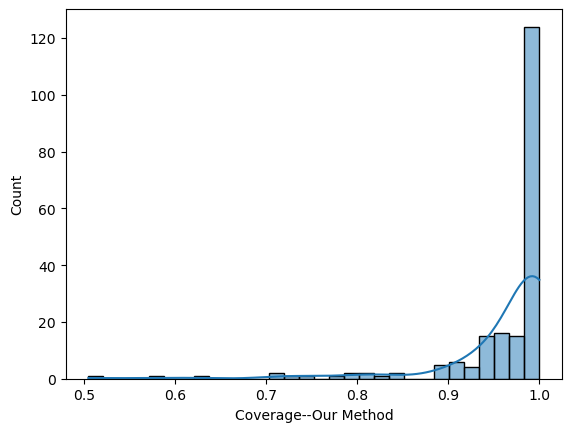

In [13]:
sns.histplot(np.array(coverage_utopia).reshape(-1, 1), kde = True, bins = 30, legend=False)
plt.xlabel('Coverage--Our Method')

Text(0.5, 0, 'Bandwidth--Our Method')

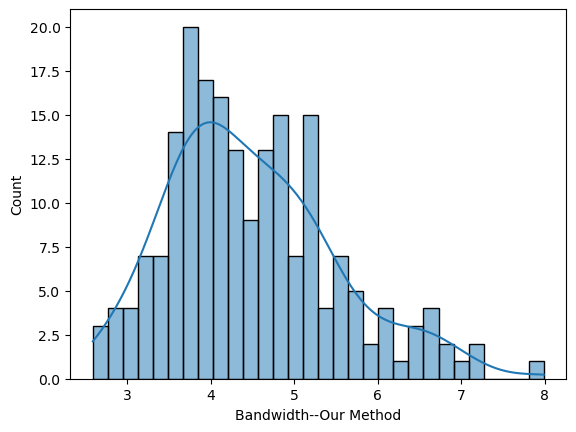

In [12]:
sns.histplot(np.array(bandwidth_utopia).reshape(-1, 1), kde = True,bins = 30, legend=False)
plt.xlabel('Bandwidth--Our Method')

In [14]:
################################## Weighted Conformal Prediction ##########################

def prob_est(Dtrain, Dshift, est_type = 'lr'):
    X_S = Dtrain[:,1:]
    X_T = Dshift[:,1:]
    n_S = X_S.shape[0]
    n_T = X_T.shape[0]
    Y_S = np.zeros(n_S).reshape(-1,1)
    Y_T = np.ones(n_T).reshape(-1,1)
    X_train = np.vstack((X_S, X_T))
    Y_train = np.vstack((Y_S, Y_T))
  
    if est_type == 'lr':
        # fit logistic regression
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            logistic_model = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000,random_state=0) 
            logistic_model.fit(X_train, Y_train[:,0])

        return logistic_model
    
    if est_type == 'rf':
        # fit random forest
        rf_model = RandomForestClassifier(n_estimators = 100, random_state=random_seed)
        rf_model.fit(X_train, Y_train[:,0])

        return rf_model

    
def ratio_est(model, X):
    
        prob_1 = model.predict_proba(X)[:,1]
        prob_1 = np.clip(prob_1, 0.01, 0.99)
        est_ratio = prob_1/(1-prob_1)
        
        return est_ratio
    
def weighting_function(model, X_calib, x_test, x):
    # Define weighting function here
    # all the data should be array
    ratio_calib = ratio_est(model, X_calib).sum()
    ratio_test = ratio_est(model, x_test)
    ratio_sum = ratio_calib + ratio_test
    ratio_x = ratio_est(model, x)
    return ratio_x/ratio_sum


def weighted_quantile(values, weights, quantile):
    
    """ Compute the weighted quantile of a 1D numpy array.
    """
    values = np.array(values)
    weights = np.array(weights)
    
    sorter = np.argsort(values)
    values = values[sorter]
    weights = weights[sorter]
    cumulative_weights = np.cumsum(weights)
    if cumulative_weights[-1]>= quantile:
        idx = np.argmax(cumulative_weights >= quantile)
        return values[idx]
    else:
        return np.max(values)


In [15]:
def weighted_conformal_cov_width(Dtrain, Dshift, alpha=0.05):
    
    n = Dshift.shape[0]
    cov = []
    width = []
    
    
    prob_est_model = prob_est(Dtrain, Dshift, est_type = 'lr')
    
    # split weighted conformal
    D = Dtrain
    np.random.shuffle(D)
    split_idx = int(D.shape[0] * 0.5)
    D1, D2 = np.split(D, [split_idx])
    X1 = D1[:,1:]
    y1 = D1[:,0]
    X2 = D2[:,1:]
    y2 = D2[:,0]
    
    # Train the model on the first part of the data
#     model = LinearRegression()
#     model.fit(X1, y1)
    
    model = LinearGAM()
    model.fit(X1, y1)
    
    # Compute the model's predictions for the calibration set
    y1_hat = model.predict(X1)
    y_calib_pred = model.predict(X2)
            
    # Calculate the absolute errors on the calibration set
    errors_calib = np.abs(y_calib_pred - y2)
    
    est_error_1 = (y1_hat - y1) ** 2
    var_model = RandomForestRegressor(n_estimators = 1000, random_state = 42, max_depth = 10)
    var_model.fit(X1, est_error_1)
    var_hat = var_model.predict(X2)
    sd_calib_pred = var_hat ** 0.5
    errors_calib = np.abs(y_calib_pred - y2)/np.clip(sd_calib_pred, 0.001, 1e10)
    
    for i in range(n):
        x_test = Dshift[i,1:]
        x_test = np.array(x_test).reshape(1,-1)
        y_test = Dshift[i,0]
    
    
        # Calculate the weights for the calibration set
        weights_calib = weighting_function(prob_est_model, X2, x_test, X2)


        # Calculate the weighted quantile of the errors
        quantile = weighted_quantile(errors_calib, weights_calib, 1 - alpha)

        # Now for the test
        y_test_pred = model.predict(x_test)
        sd_test_pred = var_model.predict(x_test) ** 0.5
        
        width.append(2*quantile*sd_test_pred)
        cov.append((np.abs(y_test - y_test_pred)/sd_test_pred) <= quantile)

    
    return np.array(cov).mean(), np.array(width).mean()


In [16]:
alpha = 0.05
def run_weighted_conformal(n):
    Dtrain, Dtest, Dshift = mydata(Data,beta)
    cov, bw = weighted_conformal_cov_width(Dtrain, Dshift, alpha)
    return cov, bw

from joblib import Parallel, delayed
results = Parallel(n_jobs=10)(delayed(run_weighted_conformal)(i) for i in range(200))

In [17]:
coverage_conformal = np.array(results)[:,0]
bandwidth_conformal = np.array(results)[:,1]
print(np.median(coverage_conformal))
print(np.median(bandwidth_conformal))
print(np.median(bandwidth_conformal[coverage_conformal >= 0.95]))
print(iqr(coverage_conformal))
print(iqr(bandwidth_conformal))

0.96875
5.045650230923089
5.681028248182514
0.03645833333333337
3.268769753867166


Text(0.5, 0, 'Coverage--Weighted variance adjusted conformal')

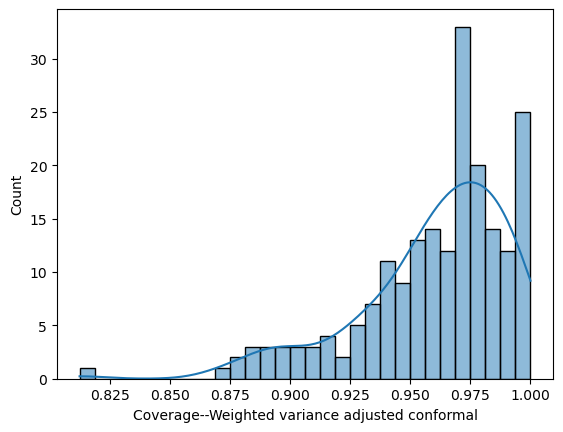

In [20]:
sns.histplot(np.array(coverage_conformal).reshape(-1, 1), kde = True, bins = 30, legend=False)
plt.xlabel('Coverage--Weighted variance adjusted conformal')

Text(0.5, 0, 'Bandwidth--Weighted variance adjusted conformal')

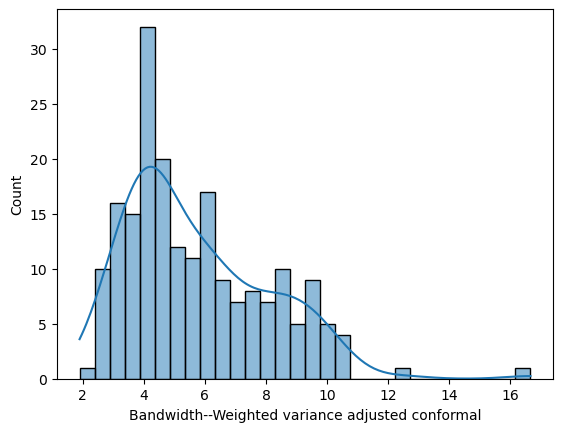

In [21]:
sns.histplot(np.array(bandwidth_conformal).reshape(-1, 1), kde = True,bins = 30, legend=False)
plt.xlabel('Bandwidth--Weighted variance adjusted conformal')

In [23]:
def weighted_conformal_quantile(Dtrain, Dshift, alpha=0.05):
    
    n = Dshift.shape[0]
    cov = []
    width = []
    
    
    prob_est_model = prob_est(Dtrain, Dshift, est_type = 'lr')
    
    # split weighted conformal
    D = Dtrain
    np.random.shuffle(D)
    split_idx = int(D.shape[0] * 0.5)
    D1, D2 = np.split(D, [split_idx])
    X1 = D1[:,1:]
    y1 = D1[:,0]
    X2 = D2[:,1:]
    y2 = D2[:,0]
    
    # Train the model on the first part of the data
    model_quantile = RandomForestQuantileRegressor(n_estimators = 500, random_state=random_seed)
    model_quantile.fit(X1, y1)
    
    y2_lb_hat = model_quantile.predict(X2, quantiles = alpha/2)
    y2_ub_hat = model_quantile.predict(X2, quantiles = (1-alpha)/2)
        
#     model_ub = QuantileRegressor(quantile = (1-alpha)/2, alpha = 1, fit_intercept=True, solver='highs', solver_options=None)
#     model_ub.fit(X1, y1)
    
#     model_lb = QuantileRegressor(quantile = alpha/2, alpha = 1, fit_intercept=True, solver='highs', solver_options=None)
#     model_lb.fit(X1, y1)
    
#     y2_lb_hat = model_lb.predict(X2)
#     y2_ub_hat = model_ub.predict(X2)
    
    errors_calib = np.maximum(y2_lb_hat - y2, y2 - y2_ub_hat)
    
    for i in range(n):
        x_test = Dshift[i,1:]
        x_test = np.array(x_test).reshape(1,-1)
        y_test = Dshift[i,0]
    
    
        # Calculate the weights for the calibration set
        weights_calib = weighting_function(prob_est_model, X2, x_test, X2)


        # Calculate the weighted quantile of the errors
        quantile = weighted_quantile(errors_calib, weights_calib, 1 - alpha)
        
        y_test_lb = model_quantile.predict(x_test, quantiles = alpha/2)
        y_test_ub = model_quantile.predict(x_test, quantiles = (1-alpha)/2)
        
        width.append(2*quantile + y_test_ub - y_test_lb)
        cov.append(y_test >= y_test_lb - quantile and y_test <= y_test_ub + quantile)

    
    return np.array(cov).mean(), np.array(width).mean()


In [24]:
alpha = 0.05
def run_weighted_conformal(n):
    Dtrain, Dtest, Dshift = mydata(Data,beta)
    cov, bw = weighted_conformal_quantile(Dtrain, Dshift, alpha)
    return cov, bw

from joblib import Parallel, delayed
results_conformal_quantile = Parallel(n_jobs=10)(delayed(run_weighted_conformal)(i) for i in range(200))

In [25]:
coverage_conformal_quantile = np.array(results_conformal_quantile)[:,0]
bandwidth_conformal_quantile = np.array(results_conformal_quantile)[:,1]
print(np.median(coverage_conformal_quantile))
print(np.median(bandwidth_conformal_quantile))
print(np.median(bandwidth_conformal[coverage_conformal_quantile >= 0.95]))
print(iqr(coverage_conformal_quantile))
print(iqr(bandwidth_conformal_quantile))

0.9739583333333334
2.841813151041667
4.938381649103942
0.04817708333333337
2.5507001953125013


Text(0.5, 0, 'Coverage--Weighted quantile conformal')

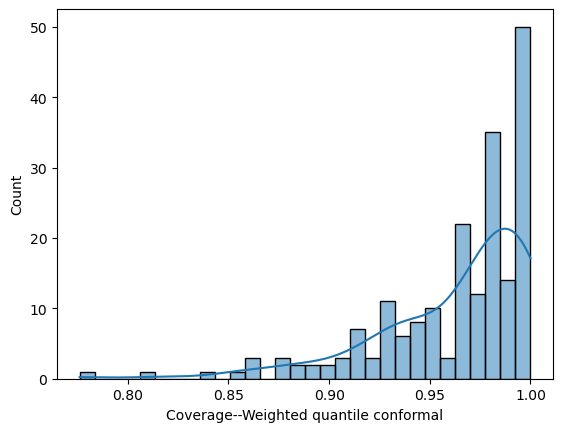

In [28]:
sns.histplot(np.array(coverage_conformal_quantile).reshape(-1, 1), kde = True, bins = 30, legend=False)
plt.xlabel('Coverage--Weighted quantile conformal')

Text(0.5, 0, 'Bandwidth--Weighted quantile conformal')

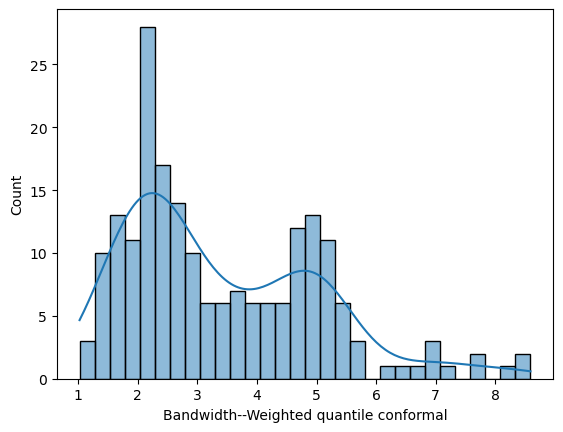

In [29]:
sns.histplot(np.array(bandwidth_conformal_quantile).reshape(-1, 1), kde = True,bins = 30, legend=False)
plt.xlabel('Bandwidth--Weighted quantile conformal')